## Zak
## Predicting Tides
## COSC 6380 - SP 2024

<b>For this assignment, I will be creating a tide prediction model using Linear Regression. I will experiment with different combinations of features to see if my model's performance is comparable to those of my teammates: Matthew, Beto, and Julia.</b>

<b>Module Imports</b>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sin, cos, radians
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.linear_model import LinearRegression
sns.set()

<b>Import Data</b>

In [2]:
df_data_1996 = pd.read_csv(f'../Data/BHPtrainingLongProcessed.zip', index_col = 'Date Time', parse_dates=True)
df_data_2016 = pd.read_csv(f'../Data/BHPtraining.csv', index_col = 'Date Time', parse_dates = True)
df_data_2020 = pd.read_csv(f'../Data/BHPtest.csv', index_col = 'Date Time', parse_dates = True)
predictions_df = pd.read_csv(f'../Data/BHPPredictions.zip', index_col = 'Date Time', parse_dates = True)
predictions_df = predictions_df.rename(columns={predictions_df.columns[0]: 'pTide'})

<b>Concatenate Data and Merge with Harmonic Predictions</b>

In [3]:
def raw_dataset():
    df_raw = pd.concat([df_data_1996, df_data_2016, df_data_2020])
    df_raw = pd.merge(df_raw, predictions_df, left_index=True, right_index=True)
    return df_raw

<b>Preprocess DataFrame</b>
<ul>
<li>Drop minute data, keep hourly</li>
<li>Create engineered features: across/along shore winds, season, surge, day/night</li>
<li>Drop unused columns: Air Temperature and Wind Direction</li>
<li>Interpolate Missing Values: 3 hours for winds, 12 hours for water levels/surge</li>
<li>Drop remaining missing values</li>
<li>Remove outliers using Z-Score</li>
</ul>

In [7]:
def preprocess(dataframe):
    # Drop minute data
    df = dataframe[dataframe.index.minute == 0].copy()
    # Calculate across and along shore winds, offset of 30 degrees
    df['uWind'] = df['Wind Speed'].multiply(np.cos(np.radians(df['Wind Direction']-30)))
    df['vWind'] = df['Wind Speed'].multiply(np.sin(np.radians(df['Wind Direction']-30)))
    # Create hour feature
    df['hour'] = df.index.hour
    # Create Season feature
    df['season'] = np.where(df.index.month.isin([12, 1, 2]), 'winter',
                                np.where(df.index.month.isin([3, 4, 5]), 'spring',
                                         np.where(df.index.month.isin([6, 7, 8]), 'summer', 'fall')))
    # Create Day/Night feature
    df['day_night'] = np.where(((df.hour >= 6) & (df.hour <= 19)), 1, 0)
    # Create dummy variables for Season, to be used in regression model
    df = pd.get_dummies(df, columns=['season'], drop_first=True)
    # Create Surge feature: Water Level - Tidal Predictions
    df['Surge'] = df['Water Level'] - df['pTide']
    # Drop unused columns: Air Temperature, Wind Direction
    df = df.drop(columns = ['Wind Direction'])
    # Remove significant outliers in Water Level
    df = df[np.abs(df['Water Level'] - df['Water Level'].mean()) <= (3 * df['Water Level'].std())]
    # Interpolate Missing Data: 3 hour limit for winds, 12 hour limit for Water Level, Surge, and Water Level Sigma
    df[['uWind', 'vWind', 'Wind Speed', 'Wind Gust', 'Air Temperature']] = df[['uWind', 'vWind', 'Wind Speed', 'Wind Gust', 'Air Temperature']].interpolate(method='linear', limit=3)
    df[['Water Level','Surge', 'Water Level Sigma']] = df[['Water Level','Surge', 'Water Level Sigma']].interpolate(method='linear', limit=12)
    # Drop remaining missing values
    df = df.dropna()

    return df

<b>After creating and cleaning out dataframe, the final processed result will look as follows: </b>

In [8]:
df_raw = raw_dataset()
df_clean = preprocess(df_raw)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124073 entries, 2001-10-28 00:00:00 to 2020-10-21 01:00:00
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Air Temperature    124073 non-null  float64
 1   Water Level        124073 non-null  float64
 2   Water Level Sigma  124073 non-null  float64
 3   Wind Speed         124073 non-null  float64
 4   Wind Gust          124073 non-null  float64
 5   pTide              124073 non-null  float64
 6   uWind              124073 non-null  float64
 7   vWind              124073 non-null  float64
 8   hour               124073 non-null  int32  
 9   day_night          124073 non-null  int32  
 10  season_spring      124073 non-null  bool   
 11  season_summer      124073 non-null  bool   
 12  season_winter      124073 non-null  bool   
 13  Surge              124073 non-null  float64
dtypes: bool(3), float64(9), int32(2)
memory usage: 10.8 MB


In [9]:
df_clean

,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Gust,pTide,uWind,vWind,hour,day_night,season_spring,season_summer,season_winter,Surge
Date Time,,,,,,,,,,,,,,
2001-10-28 00:00:00,55.8,1.437,0.056,0.00,0.00,1.005,0.000000,0.000000,0,0,False,False,False,0.432
2001-10-28 01:00:00,55.4,1.424,0.056,0.00,0.00,1.043,0.000000,0.000000,1,0,False,False,False,0.381
2001-10-28 02:00:00,54.5,1.496,0.072,0.00,0.00,1.153,0.000000,0.000000,2,0,False,False,False,0.343
2001-10-28 03:00:00,53.4,1.699,0.085,0.00,0.00,1.331,0.000000,0.000000,3,0,False,False,False,0.368
2001-10-28 04:00:00,52.3,1.804,0.052,0.00,0.00,1.537,0.000000,0.000000,4,0,False,False,False,0.267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-20 21:00:00,81.7,1.706,0.322,11.86,13.02,1.180,9.471817,7.137526,21,0,False,False,False,0.526
2020-10-20 22:00:00,80.2,2.100,0.397,12.05,14.00,1.619,8.812812,8.218080,22,0,False,False,False,0.481
2020-10-20 23:00:00,79.7,2.589,0.381,13.02,14.58,1.997,9.044452,9.365804,23,0,False,False,False,0.592


<b>I want to check for correlations in order to decide which features to use.</b>

In [136]:
df_clean.corr()

,Water Level,Water Level Sigma,Wind Speed,Wind Gust,pTide,uWind,vWind,hour,day_night,season_spring,season_summer,season_winter,Surge
Water Level,1.000000,0.189510,0.040965,0.043081,0.805192,0.085502,0.019138,0.015892,-0.001267,-0.005877,-0.088114,-0.220114,0.564252
Water Level Sigma,0.189510,1.000000,0.153090,0.151985,0.074005,0.042346,0.035087,-0.003991,0.003066,-0.114570,0.025430,-0.078917,0.216342
Wind Speed,0.040965,0.153090,1.000000,0.974134,-0.024660,0.048599,0.258270,-0.050521,-0.134582,0.112077,0.005368,-0.084268,0.103368
Wind Gust,0.043081,0.151985,0.974134,1.000000,-0.020080,0.077921,0.174116,-0.043386,-0.116650,0.112060,-0.016176,-0.073235,0.100558
pTide,0.805192,0.074005,-0.024660,-0.020080,1.000000,-0.031780,0.018218,0.012475,-0.003205,-0.002659,-0.079823,-0.296644,-0.035263
uWind,0.085502,0.042346,0.048599,0.077921,-0.031780,1.000000,-0.520184,0.086655,-0.090018,-0.001016,-0.264459,0.171073,0.188337
vWind,0.019138,0.035087,0.258270,0.174116,0.018218,-0.520184,1.000000,-0.074769,-0.191108,0.148395,0.251158,-0.303935,0.006889
hour,0.015892,-0.003991,-0.050521,-0.043386,0.012475,0.086655,-0.074769,1.000000,0.171411,0.000102,-0.000198,-0.000657,0.009414
day_night,-0.001267,0.003066,-0.134582,-0.116650,-0.003205,-0.090018,-0.191108,0.171411,1.000000,0.000412,0.000469,-0.002554,0.002327
season_spring,-0.005877,-0.114570,0.112077,0.112060,-0.002659,-0.001016,0.148395,0.000102,0.000412,1.000000,-0.323841,-0.327104,-0.006201


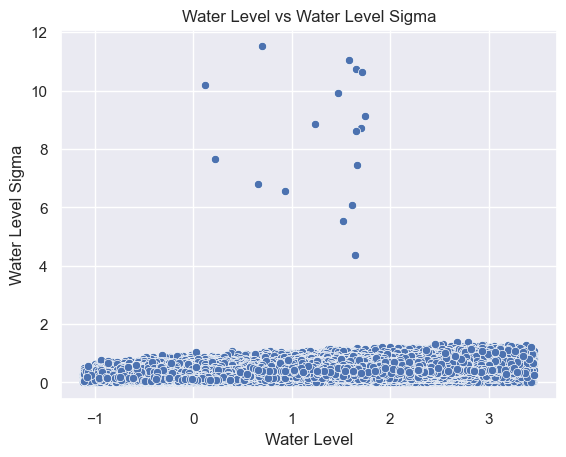

In [137]:
sns.scatterplot(data=df_clean, x='Water Level', y='Water Level Sigma')
plt.title('Water Level vs Water Level Sigma');

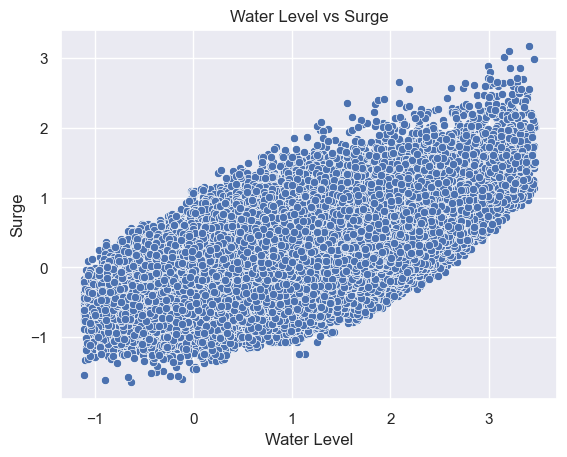

In [138]:
sns.scatterplot(data=df_clean, x='Water Level', y='Surge')
plt.title('Water Level vs Surge');

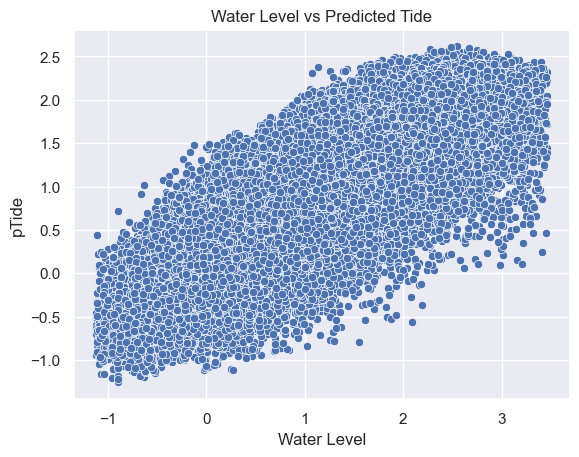

In [139]:
sns.scatterplot(data=df_clean, x='Water Level', y='pTide')
plt.title('Water Level vs Predicted Tide');

<b>It looks like Water level is most highly correlated with Surge(obviously), Water Level Sigma, and Predicted Tide. These features will definitely be included in my first model. However, I will also be experimenting with different combinations of features to see if I can improve performance. I know that my teammates also used Across and Along Shore winds, and I know that the effects of those features on tide is lagged, so I will also use those initially, for comparison.</b>

<b>Train/Validate/Test Split.</b><br> 
<b>Model will be trained on data from 1996 to 2018, validated on data from year 2019, and tested on data from year 2020.</b>

In [140]:
def data_split(dataframe):
    train = dataframe[((dataframe.index.year >= 1996) & (dataframe.index.year <= 2018))]
    validate = dataframe[dataframe.index.year == 2019]
    test = dataframe[dataframe.index.year == 2020]

    return train, validate, test

<b>We will now use a function to extract our features and labels from our datasets. For each observation at 0:00 and 12:00, we will slice our dataset into a window containing features from a starting time of 24 to 48 hours prior to our observation. Thus, each observation will now have a vector associated with it containing 24 hours worth of feature values, beginning at 24 hours into the past. </b>

In [141]:
def data_sample(df, features, leadtime_hours=24):
  data = []
  labels = []

  for index, row in df.iterrows():

    if index.hour == 0 or index.hour == 12:
        # Start and End time for 24 hours prior to observation
        end_datetime = index - pd.Timedelta(hours = leadtime_hours)
        start_datetime = end_datetime - pd.Timedelta(hours = leadtime_hours)

        # Slice the DataFrame into 24 hour windows
        window = df.loc[start_datetime:end_datetime]
        # If we do not have 24 hours of continuous data, throw out interval
        if window.shape != (leadtime_hours + 1, df.shape[1]):
            continue
    
        # Extract the ith observation for our label value
        label = None
        try:
            label = df.loc[index]['Water Level']
        except KeyError:
            continue

        # Transform each feature into a array containing 24 hours worth of values of that feature
        input_vector = []
        for feature in features:
            input_vector = input_vector + window[feature].tolist()

        data.append(input_vector)
        labels.append(label)

  return data, labels

<b>Evaluation Function: Calculate and print MSE, MAE, R2, CF, RMSE, Mean Error, Median Absolute Error</b>

In [142]:
def evaluate(predictions, labels, predictions_best):
    mse = mean_squared_error(predictions, labels)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(predictions, labels)
    median_ae = median_absolute_error(predictions, labels)
    mean_error = np.mean(predictions - labels)
    r2 = r2_score(predictions, labels)
    cf = central_frequency(predictions, labels)

    print("\nCentral Frequency:", cf)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Average Error:", mean_error)
    print("Mean Absolute Error:", mae)
    print("Median Absolute Error:", median_ae)
    print("Mean Error:", mean_error)
    print("R-squared:", r2)

    mse_best = mean_squared_error(predictions_best, labels)
    r2_best = r2_score(predictions_best, labels)
    cf_best = central_frequency(predictions_best, labels)

    print('-------------------')
    print('Difference from Current Best Model')
    print('-------------------')
    print('Central Frequency Difference: {:.6f}'.format(cf_best-cf))
    print('Mean Square Error Difference:{:.6f}'.format(mse_best-mse))
    print('R-squared Difference:{:.6f}'.format(r2_best-r2))
    print('')
def central_frequency(predictions, labels):
    temp = 0

    for i in range(0, len(predictions)):
        if abs(predictions[i] - labels[i]) <= 0.4921:
            temp = temp + 1
    return temp / len(predictions)

<b>Final evaluation function for printing performance metrics of my final model</b>

In [143]:
def evaluate_final(predictions, labels):
    mse = mean_squared_error(predictions, labels)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(predictions, labels)
    median_ae = median_absolute_error(predictions, labels)
    mean_error = np.mean(predictions - labels)
    r2 = r2_score(predictions, labels)
    cf = central_frequency(predictions, labels)

    print("\nCentral Frequency:", cf)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Average Error:", mean_error)
    print("Mean Absolute Error:", mae)
    print("Median Absolute Error:", median_ae)
    print("Mean Error:", mean_error)
    print("R-squared:", r2)
    
def central_frequency(predictions, labels):
    temp = 0

    for i in range(0, len(predictions)):
        if abs(predictions[i] - labels[i]) <= 0.4921:
            temp = temp + 1
    return temp / len(predictions)

<b>Plot function for Predictions vs. Labels</b>

In [144]:
def model_plot(predictions, labels):
    plt.figure(figsize=(25,10))
    plt.plot(labels, label='Targets')
    plt.plot(predictions, label='Predictions')
    plt.title('Predictions vs Targets', size=22)
    plt.xlabel('Observation (24hr Lag)', size=22)
    plt.ylabel('Water Level', size=22)
    plt.legend()
    plt.show()

<b>Now I will create my data/label samples for training, validation, and testing using the following features: pTide, Surge, vWind, uWind, and Water Level.</b>

In [145]:
df_train, df_validate, df_test = data_split(df_clean)

In [146]:
training_data, training_labels = data_sample(df_train, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level'])
validation_data, validation_labels = data_sample(df_validate, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level'])
testing_data, testing_labels = data_sample(df_test, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level'])

<b>Fit a Linear Regression Model to my training data</b>
<br>
<b>Features used: Harmonic Prediction, Surge, Across/Along Shore Winds, Water Level</b>
<br>
<b>Assign first model to be the best for foward propogation</b>

In [147]:
model = LinearRegression()
model.fit(training_data, training_labels)

LinearRegression()

<b>Predict my validation data with my model</b>

In [148]:
predictions = model.predict(validation_data)
predictions_best = model.predict(validation_data)

<b>Print performance metrics</b>

In [149]:
evaluate(predictions, validation_labels, predictions_best)


Central Frequency: 0.9024045261669024
Mean Squared Error: 0.0823156957269793
Root Mean Squared Error: 0.2869071203838959
Average Error: -0.10264172097121502
Mean Absolute Error: 0.22282851866436015
Median Absolute Error: 0.17395123679132762
Mean Error: -0.10264172097121502
R-squared: 0.828827454131277
-------------------
Difference from Current Best Model
-------------------
Central Frequency Difference: 0.000000
Mean Square Error Difference:0.000000
R-squared Difference:0.000000



<b>While the model had a relatively decent MSE and RMSE, the central frequency percentage was pretty low. I know that several models can predict up to 98% CF, and ours is nowhere near that range. However, we had a pretty high R-squared, which to me indicates that the model is doing pretty good at capturing the variance of the predictions.</b>

<b>Let's see graphically how our model performed</b>

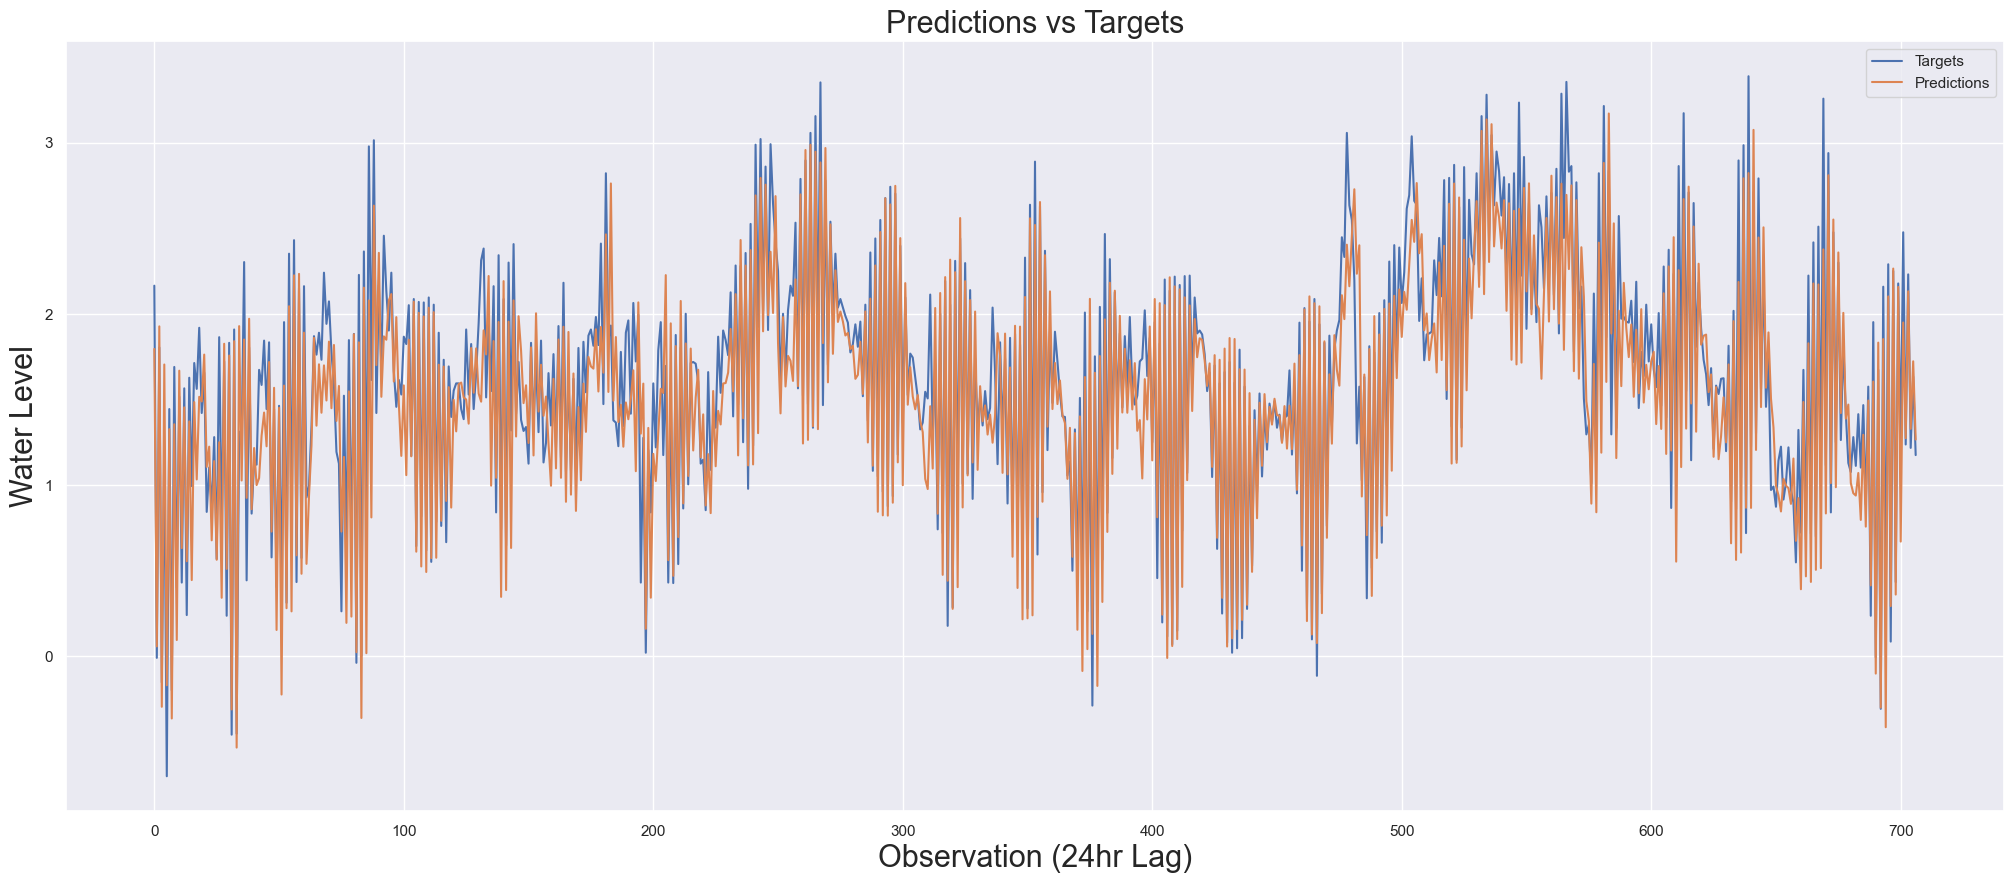

In [150]:
model_plot(predictions, validation_labels)

<b>Taking everything into consideration, it looks like my model is underfitting significantly. Although it can follow the water level trends pretty well, it is still understimating the water level for the majority of the labels.</b>

<b>Let's try to play with some features and see if we can get any sort of performance increase.</b>
<br>
<b>I will now add a feature: Day/Night. I am hoping that this will try to capture some of the effect that the moon has on the tides.</b>
<br>
<b>Features used: Harmonic Prediction, Surge, Across/Along Shore Winds, Water Level, Day/Night</b>


In [151]:
training_data, training_labels = data_sample(df_train, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level', 'day_night'])
validation_data, validation_labels = data_sample(df_validate, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level', 'day_night'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(validation_data)
evaluate(predictions, validation_labels, predictions_best)


Central Frequency: 0.9024045261669024
Mean Squared Error: 0.08231644775197725
Root Mean Squared Error: 0.2869084309531131
Average Error: -0.1026382867656819
Mean Absolute Error: 0.2228181706611464
Median Absolute Error: 0.1735254475760697
Mean Error: -0.1026382867656819
R-squared: 0.8288421488984931
-------------------
Difference from Current Best Model
-------------------
Central Frequency Difference: 0.000000
Mean Square Error Difference:-0.000001
R-squared Difference:-0.000015



<b>Well that didn't do too much. In fact, my model got even worse. Let's remove that feature and try to capture seasonality.</b>
<br>
<b>Features used: Harmonic Prediction, Surge, Across/Along Shore Winds, Water Level, Season</b>

In [152]:
training_data, training_labels = data_sample(df_train, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level','season_summer', 'season_spring', 'season_winter'])
validation_data, validation_labels = data_sample(df_validate, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level','season_summer', 'season_spring', 'season_winter'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(validation_data)
evaluate(predictions, validation_labels, predictions_best)


Central Frequency: 0.8953323903818954
Mean Squared Error: 0.08266734377058081
Root Mean Squared Error: 0.2875192928667237
Average Error: -0.10391293301804233
Mean Absolute Error: 0.22298404199043143
Median Absolute Error: 0.17607972408760464
Mean Error: -0.10391293301804233
R-squared: 0.828094533403079
-------------------
Difference from Current Best Model
-------------------
Central Frequency Difference: 0.007072
Mean Square Error Difference:-0.000352
R-squared Difference:0.000733



<b>Looks like my model using Season as a feature performed worse in all metrics. For example, the CF between my current best model and this model had a difference of +.007, so my current model's CF was still higher. Also, the MSE difference was -.0003, indicating that this current model had a higher MSE than the current best model. Finally, R-squared was also lower.</b>

<b>Let me see if adding Wind Gust, and Wind Speed will have any affect.</b>

<b>Features used: Harmonic Prediction, Surge, Across/Along Shore Winds, Water Level, Wind Speed</b>

In [153]:
training_data, training_labels = data_sample(df_train, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level', 'Wind Speed'])
validation_data, validation_labels = data_sample(df_validate, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level', 'Wind Speed'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(validation_data)
evaluate(predictions, validation_labels, predictions_best)


Central Frequency: 0.9038189533239038
Mean Squared Error: 0.08304832216138804
Root Mean Squared Error: 0.28818105795035875
Average Error: -0.10254931541049954
Mean Absolute Error: 0.2228712091536922
Median Absolute Error: 0.16809510361920332
Mean Error: -0.10254931541049954
R-squared: 0.8268906018046875
-------------------
Difference from Current Best Model
-------------------
Central Frequency Difference: -0.001414
Mean Square Error Difference:-0.000733
R-squared Difference:0.001937



<b>Features used: Harmonic Prediction, Surge, Across/Along Shore Winds, Water Level, Wind Gust</b>

In [154]:
training_data, training_labels = data_sample(df_train, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level', 'Wind Gust'])
validation_data, validation_labels = data_sample(df_validate, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level', 'Wind Gust'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(validation_data)
evaluate(predictions, validation_labels, predictions_best)


Central Frequency: 0.9038189533239038
Mean Squared Error: 0.08236336289235609
Root Mean Squared Error: 0.2869901790869438
Average Error: -0.10021513427237168
Mean Absolute Error: 0.22171310789327536
Median Absolute Error: 0.16613173691304128
Mean Error: -0.10021513427237168
R-squared: 0.8282459800603399
-------------------
Difference from Current Best Model
-------------------
Central Frequency Difference: -0.001414
Mean Square Error Difference:-0.000048
R-squared Difference:0.000581



<b>Looks like adding Wind Gust and Wind Speed improved my model's CF slightly by a difference of 0.001414, although using both features resulted in slightly higher MSE's and lower R-squared differences. However I want to test a model which uses both Wind Speed and Wind Gust, since these are the first features which have affected my CF. </b>

<b>Since Wind Speed and Wind Gust are so strongly correlated, as will be shown below, I hypothesize that my model might improve slightly more if I include them both as features</b>

In [155]:
df_clean['Wind Speed'].corr(df_clean['Wind Gust'])

0.9741342419229486

<b>Features used: Harmonic Prediction, Surge, Across/Along Shore Winds, Water Level, Wind Gust, Wind Speed</b>

In [156]:
training_data, training_labels = data_sample(df_train, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level', 'Wind Gust', 'Wind Speed'])
validation_data, validation_labels = data_sample(df_validate, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level', 'Wind Gust', 'Wind Speed'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(validation_data)
evaluate(predictions, validation_labels, predictions_best)


Central Frequency: 0.9066478076379066
Mean Squared Error: 0.08124113587530582
Root Mean Squared Error: 0.28502830714738814
Average Error: -0.09658495173062785
Mean Absolute Error: 0.22037633632667142
Median Absolute Error: 0.16963182199796356
Mean Error: -0.09658495173062785
R-squared: 0.8305294413546582
-------------------
Difference from Current Best Model
-------------------
Central Frequency Difference: -0.004243
Mean Square Error Difference:0.001075
R-squared Difference:-0.001702



<b>It's very slight, but my model's CF and R2 improved with the addition of Wind Speed. If I were to optimize based on CF and R2, then I should add Wind Gust and Wind Speed. I will set this to be my current best model.</b>

<b>I will try one final model which adds Water Level Sigma</b>

In [157]:
predictions_best = predictions

In [158]:
training_data, training_labels = data_sample(df_train, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level', 'Wind Gust', 'Wind Speed', 'Water Level Sigma'])
validation_data, validation_labels = data_sample(df_validate, ['pTide', 'Surge', 'vWind', 'uWind', 'Water Level', 'Wind Gust', 'Wind Speed', 'Water Level Sigma'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(validation_data)
evaluate(predictions, validation_labels, predictions_best)


Central Frequency: 0.9066478076379066
Mean Squared Error: 0.08137290347005058
Root Mean Squared Error: 0.2852593617570694
Average Error: -0.09653512435369813
Mean Absolute Error: 0.22075915079363254
Median Absolute Error: 0.1687891874994525
Mean Error: -0.09653512435369813
R-squared: 0.8306257326531548
-------------------
Difference from Current Best Model
-------------------
Central Frequency Difference: 0.000000
Mean Square Error Difference:-0.000132
R-squared Difference:-0.000096



<b>Looks like my model's R2 increased slightly when I added Water Level Sigma, but my MSE increased by a slightly larger factor. Although it is tempting to use Water Level Sigma as a feature, I will refrain from doing so because of the affect it had on MSE. </b>

<b>Now I want to try some backwards propogation to see if I should eliminate any of the features I started with: Harmonic Predictions, Surge, vWind, uWind, and Water Level.</b>

<b>I will first test my model without Water Level</b>

In [159]:
training_data, training_labels = data_sample(df_train, ['pTide', 'Surge', 'vWind', 'uWind', 'Wind Gust', 'Wind Speed'])
validation_data, validation_labels = data_sample(df_validate, ['pTide', 'Surge', 'vWind', 'uWind', 'Wind Gust', 'Wind Speed'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(validation_data)
evaluate(predictions, validation_labels, predictions_best)


Central Frequency: 0.9066478076379066
Mean Squared Error: 0.08124186229349845
Root Mean Squared Error: 0.28502958143585455
Average Error: -0.09658817198360649
Mean Absolute Error: 0.22037720012909207
Median Absolute Error: 0.1696517078689988
Mean Error: -0.09658817198360649
R-squared: 0.8305275615279085
-------------------
Difference from Current Best Model
-------------------
Central Frequency Difference: 0.000000
Mean Square Error Difference:-0.000001
R-squared Difference:0.000002



<b>Interestingly enough, removing Water Level from my model had a very negligible effect on my model. Although MSE and R-Squared both changed very slightly in favor of keeping Water Level. This is probably because I am using Surge as a feature, which is already linear function of Water Level. However, I will go ahead and keep Water Level, but I will note that removing it might not have any effect.</b>

<b>Now I will test my model by removing Across/Along Shore Winds</b>

In [160]:
training_data, training_labels = data_sample(df_train, ['pTide', 'Surge', 'Wind Gust', 'Wind Speed', 'Water Level'])
validation_data, validation_labels = data_sample(df_validate, ['pTide', 'Surge', 'Wind Gust', 'Wind Speed', 'Water Level'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(validation_data)
evaluate(predictions, validation_labels, predictions_best)


Central Frequency: 0.8953323903818954
Mean Squared Error: 0.08499433753107231
Root Mean Squared Error: 0.2915378835264335
Average Error: -0.10518630384267147
Mean Absolute Error: 0.2294296161394303
Median Absolute Error: 0.19111865120671
Mean Error: -0.10518630384267147
R-squared: 0.8167431590679198
-------------------
Difference from Current Best Model
-------------------
Central Frequency Difference: 0.011315
Mean Square Error Difference:-0.003753
R-squared Difference:0.013786



<b>Looks like my model's performance has taken a significant hit after removing Along/Across Shore Winds. I will keep these features.</b>

<b>Now I will test without Surge</b>

In [161]:
training_data, training_labels = data_sample(df_train, ['pTide', 'vWind', 'uWind', 'Wind Gust', 'Wind Speed', 'Water Level'])
validation_data, validation_labels = data_sample(df_validate, ['pTide', 'vWind', 'uWind', 'Wind Gust', 'Wind Speed', 'Water Level'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(validation_data)
evaluate(predictions, validation_labels, predictions_best)


Central Frequency: 0.9066478076379066
Mean Squared Error: 0.08124186229349765
Root Mean Squared Error: 0.28502958143585316
Average Error: -0.09658817198358102
Mean Absolute Error: 0.2203772001290894
Median Absolute Error: 0.16965170786923806
Mean Error: -0.09658817198358102
R-squared: 0.8305275615279113
-------------------
Difference from Current Best Model
-------------------
Central Frequency Difference: 0.000000
Mean Square Error Difference:-0.000001
R-squared Difference:0.000002



<b>Interestingly enough, my model's performance didn't change very much. This is quite possibly because I already have Harmonic Prediction and Water Level as features.</b>

<b>Finally, I will test my model without Harmonic Predictions</b>

In [162]:
training_data, training_labels = data_sample(df_train, [ 'Surge', 'vWind', 'uWind', 'Wind Gust', 'Wind Speed', 'Water Level'])
validation_data, validation_labels = data_sample(df_validate, ['Surge', 'vWind', 'uWind', 'Wind Gust', 'Wind Speed', 'Water Level'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(validation_data)
evaluate(predictions, validation_labels, predictions_best)


Central Frequency: 0.9066478076379066
Mean Squared Error: 0.08124186229349598
Root Mean Squared Error: 0.2850295814358502
Average Error: -0.09658817198357278
Mean Absolute Error: 0.22037720012908907
Median Absolute Error: 0.16965170786910766
Mean Error: -0.09658817198357278
R-squared: 0.8305275615279121
-------------------
Difference from Current Best Model
-------------------
Central Frequency Difference: 0.000000
Mean Square Error Difference:-0.000001
R-squared Difference:0.000002



<b>This is actually very interesting to me. So it looks like as long as I have 2 of either Harmonic Predictions, Water Level, and Surge, then my model's performance will not change with the addition/removal of any of those. Now obviously this is because Surge is calculated as Harmonic Predictions - Water Level, but its interesting to me to see that I do not need to use all three features. So it seems that Linear Regression is automatically utilizing the affect of Surge being a linear combination of Harmonic Prediction and Water Level, even without me specifying it as a feature.</b>

<b>However, while the difference was in fact negligible, there was a slight skew towards using all 3 as features, so I will do so in my final model.</b>

<b>Thus, my final model will use the following features, for 24 to 48 hours prior to each observation:</b>
<ul>
<li>Harmonic Prediction</li>
<li>Surge</li>
<li>Water Level</li>
<li>Across Shore Winds</li>
<li>Along Shore Winds</li>
<li>Wind Speed</li>
<li>Wind Gust</li>
</ul>

<b>I will perform a final test using my Test Data in order to get my final results.</b>


Central Frequency: 0.922509225092251
Mean Squared Error: 0.07732997531548273
Root Mean Squared Error: 0.2780826771222593
Average Error: -0.11023870658173052
Mean Absolute Error: 0.21607163754288197
Median Absolute Error: 0.17436398846323076
Mean Error: -0.11023870658173052
R-squared: 0.8470558907999968


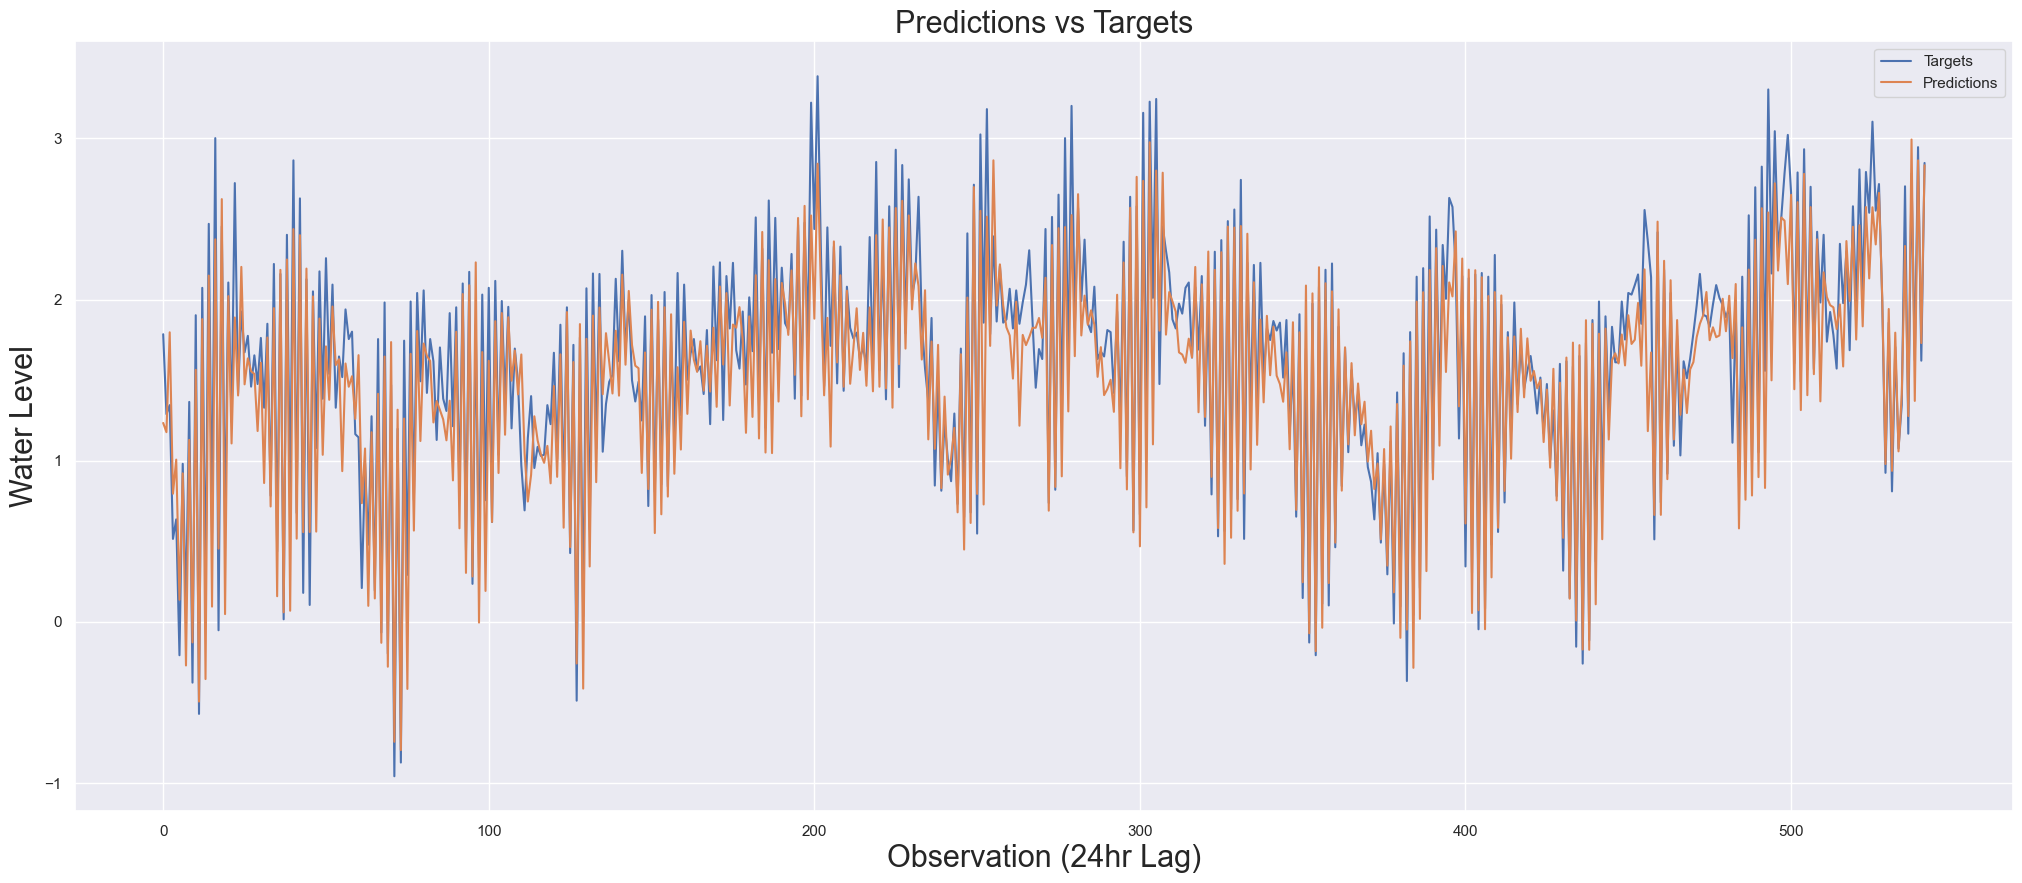

In [163]:
training_data, training_labels = data_sample(df_train, ['pTide', 'Surge', 'uWind', 'vWind', 'Wind Speed', 'Wind Gust', 'Water Level'])
testing_data, testing_labels = data_sample(df_test, ['pTide', 'Surge', 'uWind', 'vWind', 'Wind Speed', 'Wind Gust', 'Water Level'])
model = LinearRegression()
model.fit(training_data, training_labels)
predictions = model.predict(testing_data)
evaluate_final(predictions, testing_labels)
model_plot(predictions, testing_labels)

<b>Final thoughts: It looks like my model is still doing poorly at predicting some of the higher water levels, but it is doing OK at predicting the lower water levels, as well as the average values.</b>